<a href="https://colab.research.google.com/github/victor-roris/ML-learning/blob/master/ComputerVision/DeepLearning_ComputerVision_ImageClassification_FinetuningEfficientNet_DataSpartan_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MultiLabel Image Classification via fine-tuning with EfficientNet

In this notebook we generate a model via finetuning EfficientNet to classify images of figure (from a non public dataset).

Adapted from [link](https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/)

## Introduction

### What is EfficientNet?

EfficientNet, first introduced in [Tan and Le, 2019](https://arxiv.org/abs/1905.11946)
is among the most efficient models (i.e. requiring least FLOPS for inference)
that reaches State-of-the-Art accuracy on both
imagenet and common image classification transfer learning tasks.

The smallest base model is similar to [MnasNet](https://arxiv.org/abs/1807.11626), which
reached near-SOTA with a significantly smaller model. By introducing a heuristic way to
scale the model, EfficientNet provides a family of models (B0 to B7) that represents a
good combination of efficiency and accuracy on a variety of scales. Such a scaling
heuristics (compound-scaling, details see
[Tan and Le, 2019](https://arxiv.org/abs/1905.11946)) allows the
efficiency-oriented base model (B0) to surpass models at every scale, while avoiding
extensive grid-search of hyperparameters.

A summary of the latest updates on the model is available at
[here](https://github.com/tensorflow/tpu/tree/master/models/official/efficientnet), where various
augmentation schemes and semi-supervised learning approaches are applied to further
improve the imagenet performance of the models. These extensions of the model can be used
by updating weights without changing model architecture.

### B0 to B7 variants of EfficientNet

*(This section provides some details on "compound scaling", and can be skipped
if you're only interested in using the models)*

Based on the [original paper](https://arxiv.org/abs/1905.11946) people may have the
impression that EfficientNet is a continuous family of models created by arbitrarily
choosing scaling factor in as Eq.(3) of the paper.  However, choice of resolution,
depth and width are also restricted by many factors:

- Resolution: Resolutions not divisible by 8, 16, etc. cause zero-padding near boundaries
of some layers which wastes computational resources. This especially applies to smaller
variants of the model, hence the input resolution for B0 and B1 are chosen as 224 and
240.

- Depth and width: The building blocks of EfficientNet demands channel size to be
multiples of 8.

- Resource limit: Memory limitation may bottleneck resolution when depth
and width can still increase. In such a situation, increasing depth and/or
width but keep resolution can still improve performance.

As a result, the depth, width and resolution of each variant of the EfficientNet models
are hand-picked and proven to produce good results, though they may be significantly
off from the compound scaling formula.
Therefore, the keras implementation (detailed below) only provide these 8 models, B0 to B7,
instead of allowing arbitray choice of width / depth / resolution parameters.

### Keras implementation of EfficientNet



An implementation of EfficientNet B0 to B7 has been shipped with tf.keras since TF2.3. To
use EfficientNetB0 for classifying 1000 classes of images from imagenet, run:

```python
from tensorflow.keras.applications import EfficientNetB0
model = EfficientNetB0(weights='imagenet')
```

This model takes input images of shape (224, 224, 3), and the input data should range
[0, 255]. Normalization is included as part of the model.

Because training EfficientNet on ImageNet takes a tremendous amount of resources and
several techniques that are not a part of the model architecture itself. Hence the Keras
implementation by default loads pre-trained weights obtained via training with
[AutoAugment](https://arxiv.org/abs/1805.09501).

For B0 to B7 base models, the input shapes are different. Here is a list of input shape
expected for each model:

| Base model | resolution|
|----------------|-----|
| EfficientNetB0 | 224 |
| EfficientNetB1 | 240 |
| EfficientNetB2 | 260 |
| EfficientNetB3 | 300 |
| EfficientNetB4 | 380 |
| EfficientNetB5 | 456 |
| EfficientNetB6 | 528 |
| EfficientNetB7 | 600 |

When the model is intended for transfer learning, the Keras implementation
provides a option to remove the top layers:
```
model = EfficientNetB0(include_top=False, weights='imagenet')
```
This option excludes the final `Dense` layer that turns 1280 features on the penultimate
layer into prediction of the 1000 ImageNet classes. Replacing the top layer with custom
layers allows using EfficientNet as a feature extractor in a transfer learning workflow.

Another argument in the model constructor worth noticing is `drop_connect_rate` which controls
the dropout rate responsible for [stochastic depth](https://arxiv.org/abs/1603.09382).
This parameter serves as a toggle for extra regularization in finetuning, but does not
affect loaded weights. For example, when stronger regularization is desired, try:

```python
model = EfficientNetB0(weights='imagenet', drop_connect_rate=0.4)
```
The default value is 0.2.


## Use of EfficientNetB0 for figure/photo prediction

EfficientNet is capable of a wide range of image classification tasks.
This makes it a good model for transfer learning.

In this notebook we apply the model to classify images of figure (from a **non public dataset**).

In [1]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np


from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


## Setup

This example requires TensorFlow 2.3 or above.

To use TPU, the TPU runtime must match current running TensorFlow
version. If there is a mismatch, try:

```python
from cloud_tpu_client import Client
c = Client()
c.configure_tpu_version(tf.__version__, restart_type="always")
```

In [2]:
!pip install tensorflow==2.3
clear_output()

In [28]:
print(f"If this import fails you need restart environment")
from tensorflow.keras.applications import EfficientNetB0

If this import fails you need restart environment


In [2]:
import tensorflow as tf

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()


Not connected to a TPU runtime. Using CPU/GPU strategy
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


## Dataset

### Download

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
dataset_folderpath = "/content/input"

In [5]:
import os
if os.path.isdir(dataset_folderpath):
  !rm -R {dataset_folderpath}

In [6]:
from pathlib import Path
def mkdir(sfolderpath):
  folderpath = Path(sfolderpath)
  folderpath.mkdir(parents=True, exist_ok=True)

mkdir(dataset_folderpath)

In [7]:
!tar -xvf /content/drive/My\ Drive/DATASPARTAN/PROYECTOS/AI-DOCUMENTS/SEGMENTATION/DSFigureDataset.tar.gz -C {dataset_folderpath}

clear_output()

!ls {dataset_folderpath}

raw  setup.py


### Split train, val and test dataset

The `zip` contains a script to generate the ml dataset

In [8]:
% cd {dataset_folderpath}
!python setup.py

%cd /content/

/content/input
Number of classes : 20
['VennDiagram', 'AreaGraph', 'BubbleChart', 'RadarPlot', 'PersonPhoto', 'TreeDiagram', 'LineGraph', 'NetworkDiagram', 'Map', 'ScatterGraph', 'HorizontalBarGraph', 'GeneralPhoto', 'ParetoChart', 'GeneralFigure', 'Signatures', 'FlowChart', 'BoxPlot', 'Table', 'PieChart', 'VerticalBarGraph']
VennDiagram: 
   > ntrain : 213
   > nval : 88
   > ntest : 4

AreaGraph: 
   > ntrain : 157
   > nval : 65
   > ntest : 3

BubbleChart: 
   > ntrain : 170
   > nval : 70
   > ntest : 3

RadarPlot: 
   > ntrain : 160
   > nval : 66
   > ntest : 3

PersonPhoto: 
   > ntrain : 160
   > nval : 66
   > ntest : 3

TreeDiagram: 
   > ntrain : 164
   > nval : 68
   > ntest : 3

LineGraph: 
   > ntrain : 156
   > nval : 65
   > ntest : 3

NetworkDiagram: 
   > ntrain : 183
   > nval : 76
   > ntest : 3

Map: 
   > ntrain : 271
   > nval : 113
   > ntest : 4

ScatterGraph: 
   > ntrain : 146
   > nval : 60
   > ntest : 3

HorizontalBarGraph: 
   > ntrain : 149
   > nval : 

In [9]:
!ls {dataset_folderpath}/dataset

test  test_raw	train  val


In [10]:
input_folder = "/content/input/dataset"

trn_folder = os.path.join(input_folder,"train")
val_folder = os.path.join(input_folder,"val")
test_folder = os.path.join(input_folder,"test")
testraw_folder = os.path.join(input_folder,"test_raw")

In [11]:
classes = [name for name in os.listdir(trn_folder) 
      if os.path.isdir(os.path.join(trn_folder,name))]
classes.sort()
NUM_CLASSES = len(classes)
print(f"Number of classes : {NUM_CLASSES}")
print(classes)

Number of classes : 20
['AreaGraph', 'BoxPlot', 'BubbleChart', 'FlowChart', 'GeneralFigure', 'GeneralPhoto', 'HorizontalBarGraph', 'LineGraph', 'Map', 'NetworkDiagram', 'ParetoChart', 'PersonPhoto', 'PieChart', 'RadarPlot', 'ScatterGraph', 'Signatures', 'Table', 'TreeDiagram', 'VennDiagram', 'VerticalBarGraph']


### Dataset loading

When the dataset include images with various size, we need to resize them into a
shared size. Here we resize the images to the input size needed for EfficientNet.

In [12]:
# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 224
size = (IMG_SIZE, IMG_SIZE)
batch_size = 64

In [13]:
# With transform
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=15,
                    width_shift_range=.10,
                    height_shift_range=.10,
                    brightness_range= [0.7, 1.3],
                    horizontal_flip=True,
                    zoom_range=[0.8, 1.2]
                    )

In [14]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=trn_folder,
                                                     shuffle=True,
                                                     target_size=size,
                                                     class_mode='categorical')

Found 3520 images belonging to 20 classes.


In [15]:
total_train=len(train_data_gen.filenames)
total_train

3520

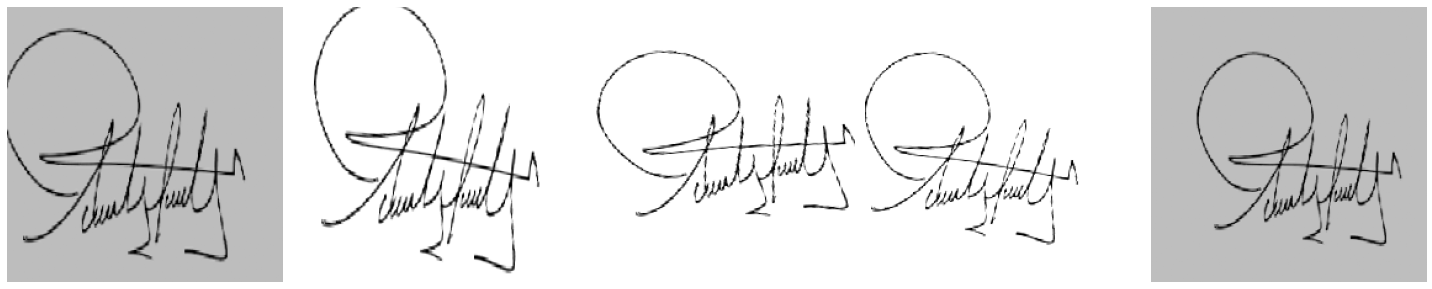

In [16]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [17]:
image_gen_val = ImageDataGenerator(rescale=1./255)

In [18]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=val_folder,
                                                 target_size=size,
                                                 class_mode='categorical')

Found 1458 images belonging to 20 classes.


In [19]:
total_val=len(val_data_gen.filenames)
total_val

1458

The `test` dataset is a list of images in a folder without associated label.


In [20]:
test_images = []
shape = size

for filename in os.listdir(testraw_folder):
  img = cv2.imread(os.path.join(testraw_folder,filename))

  # Resize all images to a specific shape
  img = cv2.resize(img,shape)

  test_images.append(img)
        
# Converting test_images to array
test_images = np.array(test_images)

## Training a model from scratch

We build an EfficientNetB0 with custom output classes, that is initialized from scratch:

Note: the accuracy will increase very slowly and may overfit.

In [41]:
from tensorflow.keras.applications import EfficientNetB0

with strategy.scope():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    outputs = EfficientNetB0(include_top=True, weights=None, classes=NUM_CLASSES)(inputs)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

model.summary()


Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 20)                4075191   
Total params: 4,075,191
Trainable params: 4,033,168
Non-trainable params: 42,023
_________________________________________________________________


In [42]:
epochs = 60  # @param {type: "slider", min:10, max:100}
hist = model.fit(train_data_gen,
                 epochs=epochs,
                 validation_data=val_data_gen,
                 verbose=2)

Epoch 1/60
55/55 - 90s - loss: 3.6625 - accuracy: 0.0744 - val_loss: 3.0187 - val_accuracy: 0.0453
Epoch 2/60
55/55 - 87s - loss: 3.1020 - accuracy: 0.1324 - val_loss: 3.0551 - val_accuracy: 0.0775
Epoch 3/60
55/55 - 87s - loss: 2.8422 - accuracy: 0.1676 - val_loss: 3.1785 - val_accuracy: 0.0453
Epoch 4/60
55/55 - 86s - loss: 2.6442 - accuracy: 0.2162 - val_loss: 3.2772 - val_accuracy: 0.0412
Epoch 5/60
55/55 - 87s - loss: 2.3995 - accuracy: 0.2634 - val_loss: 3.7511 - val_accuracy: 0.0460
Epoch 6/60
55/55 - 88s - loss: 2.2283 - accuracy: 0.3216 - val_loss: 3.4380 - val_accuracy: 0.0473
Epoch 7/60
55/55 - 89s - loss: 2.0778 - accuracy: 0.3659 - val_loss: 3.9342 - val_accuracy: 0.0446
Epoch 8/60
55/55 - 88s - loss: 1.9863 - accuracy: 0.3830 - val_loss: 4.5186 - val_accuracy: 0.0446
Epoch 9/60
55/55 - 88s - loss: 1.8568 - accuracy: 0.4134 - val_loss: 5.8059 - val_accuracy: 0.0453
Epoch 10/60
55/55 - 88s - loss: 1.7584 - accuracy: 0.4381 - val_loss: 3.9531 - val_accuracy: 0.0933
Epoch 11/

Training the model is relatively fast (takes only 20 seconds per epoch on TPUv2 that is
available on Colab). This might make it sounds easy to simply train EfficientNet on any
dataset wanted from scratch. However, training EfficientNet on smaller datasets,
especially those with lower resolution like CIFAR-100, faces the significant challenge of
overfitting.

Hence training from scratch requires very careful choice of hyperparameters and is
difficult to find suitable regularization. It would also be much more demanding in resources.
Plotting the training and validation accuracy
makes it clear that validation accuracy stagnates at a low value.

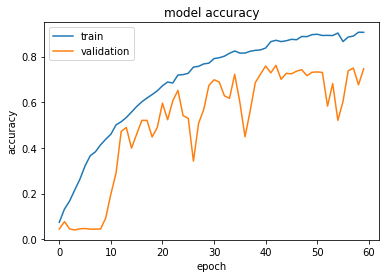

In [43]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

In [44]:
model.save("/content/efficientNet_model.h5")
!ls -lah

total 48M
drwxr-xr-x 1 root root 4.0K Jul 30 13:57 .
drwxr-xr-x 1 root root 4.0K Jul 30 10:13 ..
drwxr-xr-x 1 root root 4.0K Jul 22 16:16 .config
drwx------ 4 root root 4.0K Jul 30 10:24 drive
-rw-r--r-- 1 root root  48M Jul 30 13:57 efficientNet_model.h5
drwxr-xr-x 4 root root 4.0K Jul 30 10:28 input
drwxr-xr-x 1 root root 4.0K Jul 10 16:29 sample_data


In [45]:
!cp /content/efficientNet_model.h5 /content/drive/My\ Drive/efficientNet_model.h5

## Transfer learning from pre-trained weights

Here we initialize the model with pre-trained ImageNet weights,
and we fine-tune it on our own dataset.

In [54]:
from tensorflow.keras.layers.experimental import preprocessing


def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")

    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

    # optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    # model.compile(
    #     optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    # )
    return model

with strategy.scope():
    model = build_model(num_classes=NUM_CLASSES)

model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_10 (Rescaling)        (None, 224, 224, 3)  0           input_13[0][0]                   
__________________________________________________________________________________________________
normalization_10 (Normalization (None, 224, 224, 3)  7           rescaling_10[0][0]               
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_10[0][0]           
_______________________________________________________________________________________

The first step to transfer learning is to freeze all layers and train only the top
layers. For this step, a relatively large learning rate (1e-2) can be used.
Note that validation accuracy and loss will usually be better than training
accuracy and loss. This is because the regularization is strong, which only
suppresses training-time metrics.

Note that the convergence may take up to 50 epochs depending on choice of learning rate.
If image augmentation layers were not
applied, the validation accuracy may only reach ~60%.

In [ ]:
epochs = 50  # @param {type: "slider", min:8, max:80}
hist = model.fit(train_data_gen,
                 epochs=epochs,
                 validation_data=val_data_gen,
                 verbose=2)
plot_hist(hist)

Epoch 1/50
55/55 - 79s - loss: 3.1868 - accuracy: 0.0514 - val_loss: 2.9724 - val_accuracy: 0.0775
Epoch 2/50
55/55 - 76s - loss: 3.1486 - accuracy: 0.0565 - val_loss: 2.9703 - val_accuracy: 0.0775
Epoch 3/50
55/55 - 77s - loss: 3.1413 - accuracy: 0.0622 - val_loss: 2.9693 - val_accuracy: 0.0775
Epoch 4/50
55/55 - 76s - loss: 3.1175 - accuracy: 0.0634 - val_loss: 2.9691 - val_accuracy: 0.0775
Epoch 5/50
55/55 - 77s - loss: 3.1284 - accuracy: 0.0625 - val_loss: 2.9690 - val_accuracy: 0.0775
Epoch 6/50
55/55 - 77s - loss: 3.1311 - accuracy: 0.0688 - val_loss: 2.9678 - val_accuracy: 0.0775
Epoch 7/50
55/55 - 77s - loss: 3.1243 - accuracy: 0.0676 - val_loss: 2.9672 - val_accuracy: 0.0768
Epoch 8/50
55/55 - 77s - loss: 3.1040 - accuracy: 0.0619 - val_loss: 2.9667 - val_accuracy: 0.0782
Epoch 9/50
55/55 - 77s - loss: 3.0922 - accuracy: 0.0682 - val_loss: 2.9666 - val_accuracy: 0.0789
Epoch 10/50
55/55 - 77s - loss: 3.1102 - accuracy: 0.0679 - val_loss: 2.9701 - val_accuracy: 0.0823
Epoch 11/

The second step is to unfreeze a number of layers and fit the model using smaller
learning rate. In this example we show unfreezing all layers, but depending on
specific dataset it may be desireble to only unfreeze a fraction of all layers.

When the feature extraction with
pretrained model works good enough, this step would give a very limited gain on
validation accuracy. In our case we only see a small improvement,
as ImageNet pretraining already exposed the model to a good amount of dogs.

On the other hand, when we use pretrained weights on a dataset that is more different
from ImageNet, this fine-tuning step can be crucial as the feature extractor also
needs to be adjusted by a considerable amount. Such a situation can be demonstrated
if choosing CIFAR-100 dataset instead, where fine-tuning boosts validation accuracy
by about 10% to pass 80% on `EfficientNetB0`.
In such a case the convergence may take more than 50 epochs.

A side note on freezing/unfreezing models: setting `trainable` of a `Model` will
simultaneously set all layers belonging to the `Model` to the same `trainable`
attribute. Each layer is trainable only if both the layer itself and the model
containing it are trainable. Hence when we need to partially freeze/unfreeze
a model, we need to make sure the `trainable` attribute of the model is set
to `True`.

Epoch 1/10
55/55 - 78s - loss: 2.9750 - accuracy: 0.0776 - val_loss: 2.9891 - val_accuracy: 0.0775
Epoch 2/10
55/55 - 76s - loss: 2.9725 - accuracy: 0.0798 - val_loss: 3.0251 - val_accuracy: 0.0480
Epoch 3/10
55/55 - 76s - loss: 2.9675 - accuracy: 0.0753 - val_loss: 3.0377 - val_accuracy: 0.0487
Epoch 4/10
55/55 - 76s - loss: 2.9677 - accuracy: 0.0773 - val_loss: 3.1027 - val_accuracy: 0.0494
Epoch 5/10
55/55 - 76s - loss: 2.9693 - accuracy: 0.0764 - val_loss: 2.9731 - val_accuracy: 0.0789
Epoch 6/10
55/55 - 77s - loss: 2.9633 - accuracy: 0.0795 - val_loss: 3.0669 - val_accuracy: 0.0494
Epoch 7/10
55/55 - 76s - loss: 2.9613 - accuracy: 0.0807 - val_loss: 2.9870 - val_accuracy: 0.0494
Epoch 8/10
55/55 - 75s - loss: 2.9561 - accuracy: 0.0864 - val_loss: 3.0059 - val_accuracy: 0.0850
Epoch 9/10
55/55 - 76s - loss: 2.9603 - accuracy: 0.0795 - val_loss: 3.0131 - val_accuracy: 0.0508
Epoch 10/10
55/55 - 76s - loss: 2.9535 - accuracy: 0.0872 - val_loss: 3.3296 - val_accuracy: 0.0494


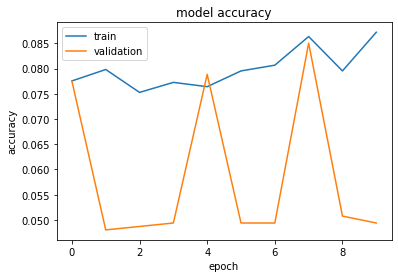

In [36]:

def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

epochs = 10  # @param {type: "slider", min:8, max:50}
hist = model.fit(train_data_gen,
                 epochs=epochs,
                 validation_data=val_data_gen,
                 verbose=2)
plot_hist(hist)

* **Predict**

In [ ]:
test_data_gen = image_gen_val.flow_from_directory(batch_size=1,
                                                 directory=test_folder,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='categorical')

number_of_examples = len(test_data_gen.filenames)
test_labels = []
for i in range(0,number_of_examples):
    test_labels.extend(np.array(test_data_gen[i][1]))

In [ ]:
#Making prediction
y_pred=model.predict(test_data_gen, steps=number_of_examples)
y_pred=np.argmax(y_pred,axis=1)
y_true=np.argmax(test_labels,axis=1)

### Tips for fine tuning EfficientNet

On unfreezing layers:

- The `BathcNormalization` layers need to be kept frozen
([more details](https://keras.io/guides/transfer_learning/)).
If they are also turned to trainable, the
first epoch after unfreezing will significantly reduce accuracy.
- In some cases it may be beneficial to open up only a portion of layers instead of
unfreezing all. This will make fine tuning much faster when going to larger models like
B7.
- Each block needs to be all turned on or off. This is because the architecture includes
a shortcut from the first layer to the last layer for each block. Not respecting blocks
also significantly harms the final performance.

Some other tips for utilizing EfficientNet:

- Larger variants of EfficientNet do not guarantee improved performance, especially for
tasks with less data or fewer classes. In such a case, the larger variant of EfficientNet
chosen, the harder it is to tune hyperparameters.
- EMA (Exponential Moving Average) is very helpful in training EfficientNet from scratch,
but not so much for transfer learning.
- Do not use the RMSprop setup as in the original paper for transfer learning. The
momentum and learning rate are too high for transfer learning. It will easily corrupt the
pretrained weight and blow up the loss. A quick check is to see if loss (as categorical
cross entropy) is getting significantly larger than log(NUM_CLASSES) after the same
epoch. If so, the initial learning rate/momentum is too high.
- Smaller batch size benefit validation accuracy, possibly due to effectively providing
regularization.

## Using the latest EfficientNet weights

Since the initial paper, the EfficientNet has been improved by various methods for data
preprocessing and for using unlabelled data to enhance learning results. These
improvements are relatively hard and computationally costly to reproduce, and require
extra code; but the weights are readily available in the form of TF checkpoint files. The
model architecture has not changed, so loading the improved checkpoints is possible.

To use a checkpoint provided at
[the official model repository](https://github.com/tensorflow/tpu/tree/master/models/official/efficientnet), first
download the checkpoint. As example, here we download noisy-student version of B1:

```
!wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet\
       /noisystudent/noisy_student_efficientnet-b1.tar.gz
!tar -xf noisy_student_efficientnet-b1.tar.gz
```

Then use the script efficientnet_weight_update_util.py to convert ckpt file to h5 file.

```
!python efficientnet_weight_update_util.py --model b1 --notop --ckpt \
        efficientnet-b1/model.ckpt --o efficientnetb1_notop.h5
```

When creating model, use the following to load new weight:

```python
model = EfficientNetB0(weights="efficientnetb1_notop.h5", include_top=False)
```